Técnicas para evitar el sobreajuste de modelos --- 37:15 min
===

* Última modificación: Mayo 10, 2021 | [YouTube](https://youtu.be/vGkJSNjFLZs)

Adaptado de:

* https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [1]:
#
# Paquetes a instalar en Google Colab
#

# !pip install git+https://github.com/tensorflow/docs

## Higgs Dataset

In [2]:
#
# Descarga el archivo en formato csv.gz (comprimido)
# 
# El dataset original contiene 11.000.000 de ejemplos 
# y 28 variables independientes. La variable dependiente
# es binaria.
#
# Para este ejemplo, y tal como se hace en el tutorial
# original de TensorFlow se usaran 11.000 ejemplos. Ya
# que el tiempo de descarga es largo debido al tamaño 
# del archivo original, se creo un archivo que contiene
# unicamente los ejemplos usados en esta lección.
#
# !wget https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/HIGGS-tiny.csv.gz

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


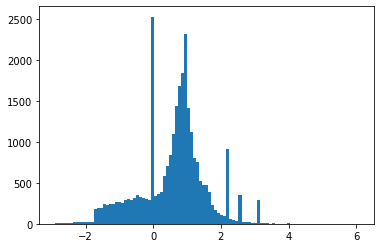

In [3]:
import tensorflow as tf

#
# Número de variables independientes
#
FEATURES = 28

#
# Lee directamente los datos comprimidos
# en formato gz
#
ds = tf.data.experimental.CsvDataset(
    #
    # Nombre del archivo
    #
    "HIGGS-tiny.csv.gz",
    #
    # Valores por defecto para las columnas
    # del dataset: float32, float64, int32,
    #  int64, string.
    #
    [
        float(),
    ]
    * (FEATURES + 1),
    #
    # Formato:
    # - "": sin compresión
    # - "ZLIB"
    # - "GZIP"
    #
    compression_type="GZIP",
)

#
# La primera columa es la variable dependiente
# y las demás corresponden a las variables
# independientes. La función empaqueta los datos
# aplicando la función pack_row a cada fila del
# dataframe
#
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label


#
#  En vez de aplicar la función individualmente a
#  cada patrón, primero se empaqueta en grupos de
#  10.000 patrónes, se aplica la función map(), y
#  finalmente se retornan los registros individuales
#
packed_ds = ds.batch(10000).map(pack_row).unbatch()

#
# Histograma de las variables independientes.
# Son aproximadamente normales
#
import matplotlib.pyplot as plt

for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

## Conjuntos de entrenamiento y validación

In [4]:
#
# Usa los primeros 1000 para validacion
#
N_VALIDATION = 1000
N_TRAIN = 10000
BUFFER_SIZE = 10000
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()

#
# Ignora los primeros 1000 (validación) y toma los 
# siguientes 10.000 para entrenamiento. El método 
# cache hace que no se relean registros del 
# archivo en disco en cada epoch.
#
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

#
# Define el tamaño de los bloques
#
validate_ds = validate_ds.batch(BATCH_SIZE)

#
# Mezcla los patrones de entrenamiento
#
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Variación de la tasa de aprendizaje

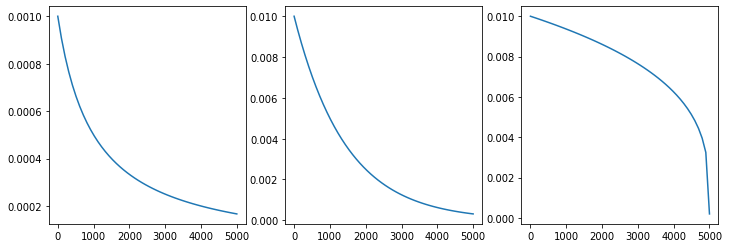

In [5]:
import numpy as np


#
# La siguiente función grafica tres esquemas
#  diferentes de variación de la tasa de aprendizaje
#
def plot_schedules():

    plt.figure(figsize=(12, 4))

    step = np.linspace(0, 100000)

    plt.subplot(1, 3, 1)
    schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=STEPS_PER_EPOCH * 1000,
        decay_rate=1,
        staircase=False,
    )
    lr = schedule(step)
    plt.plot(step / STEPS_PER_EPOCH, lr)

    plt.subplot(1, 3, 2)
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=STEPS_PER_EPOCH * 1000,
        decay_rate=0.5,
        staircase=False,
    )
    lr = schedule(step)
    plt.plot(step / STEPS_PER_EPOCH, lr)

    plt.subplot(1, 3, 3)
    schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=0.01,
        decay_steps=STEPS_PER_EPOCH * 5000,
        end_learning_rate=0.0002,
        power=0.3,
        cycle=False,
    )
    lr = schedule(step)
    plt.plot(step / STEPS_PER_EPOCH, lr)

    plt.show()


plot_schedules()

## Callbacks

In [6]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

#
# Define el directorio de trabajo para almacenar
# la información que requiere TensorBoard
#
LOGDIR = "/tmp/tensorboard_logs"

#
# Borra el directorio si existe
#
!rm -rf {LOGDIR}


#
# Define las funciones que se llamaran en cada
# iteración del entrenamiento. La función 
# retorna una lista de callbacks.
#
def get_callbacks(name):
    return [
        # 
        # Simplemente imprime un "." en cada epoch
        #
        tfdocs.modeling.EpochDots(),
        
        #
        # Los callbacks son utilidades que se llaman durante el
        # entrenamiento de un modelo.
        #
        # EarlyStopping detiene el entrenamiento si la métrica
        # monitoreada no mejora durante "patiente" iteraciones
        #
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy",
            patience=200,
            verbose=0,
        ),
        
        #
        # Almacena la información requerida para visualizar
        # los resultados en TensorBoard
        #
        tf.keras.callbacks.TensorBoard(LOGDIR + "/" + name),
    ]

In [7]:
#
# Esta es una función auxiliar que recibe
#  un modelo y un string para identificarlo.
#
def compile_and_fit(model, name):

    MAX_EPOCHS = 10000

    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=STEPS_PER_EPOCH * 1000,
        decay_rate=1,
        staircase=False,
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.losses.BinaryCrossentropy(
                from_logits=True,
                name="binary_crossentropy",
            ),
            "accuracy",
        ],
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=MAX_EPOCHS,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0,
    )

    return history

In [8]:
#
# Crea modelos con distintos tamaños y cantidad
# de parámetros y los entrena.
#
tiny_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            16,
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(1),
    ]
)

small_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            16,
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            16,
            activation="elu",
        ),
        tf.keras.layers.Dense(1),
    ]
)

medium_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            64,
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            64,
            activation="elu",
        ),
        tf.keras.layers.Dense(
            64,
            activation="elu",
        ),
        tf.keras.layers.Dense(1),
    ]
)

large_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
        ),
        tf.keras.layers.Dense(1),
    ]
)

In [9]:
#
# Crea un diccionario para guardar los resultados
# de las corridas
#
size_histories = {}

In [10]:
#
# El siguiente grupo de celdas crea modelos de
# distintos tamños y los entrena. Almacena la
# historia retornada por cada modelo
#
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4790,  binary_crossentropy:0.7541,  loss:0.7541,  val_accuracy:0.5090,  val_binary_crossentropy:0.7112,  val_loss:0.7112,  
....................................................................................................
Epoch: 100, accuracy:0.5960,  binary_crossentropy:0.6272,  loss:0.6272,  val_accuracy:0.5580,  val_binary_crossentropy:0.6343,  val_loss:0.6343,  
....................................................................................................
Epoch: 200, accuracy:0.60

In [11]:
size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4870,  binary_crossentropy:0.7541,  loss:0.7541,  val_accuracy:0.4740,  val_binary_crossentropy:0.7194,  val_loss:0.7194,  
....................................................................................................
Epoch: 100, accuracy:0.6185,  binary_crossentropy:0.6147,  loss:0.6147,  val_accuracy:0.6040,  val_binary_crossentropy:0.6114,  val_loss:0.

In [12]:
size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4889,  binary_crossentropy:0.6948,  loss:0.6948,  val_accuracy:0.5000,  val_binary_crossentropy:0.6810,  val_loss:0.6810,  
....................................................................................................
E

In [13]:
size_histories["large"] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5080,  binary_crossentropy:0.8088,  loss:0.8088,  val_accuracy:0.5740,  val_binary_crossentr

In [14]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6839,  binary_crossentropy:0.5710,  loss:0.5710,  val_accuracy:0.6830,  val_binary_crossentropy:0.5851,  val_loss:0.5851,  
....................................................................................................
Epoch: 100, accuracy:0.6859,  binary_crossentropy:0.5695,  loss:0.5695,  val_accuracy:0.6870,  val_binary_crossentropy:0.5845,  val_loss:0.5845,  
....................................................................................................
Epoch: 200, accuracy:0.68

## Resultados obtenidos para los modelos

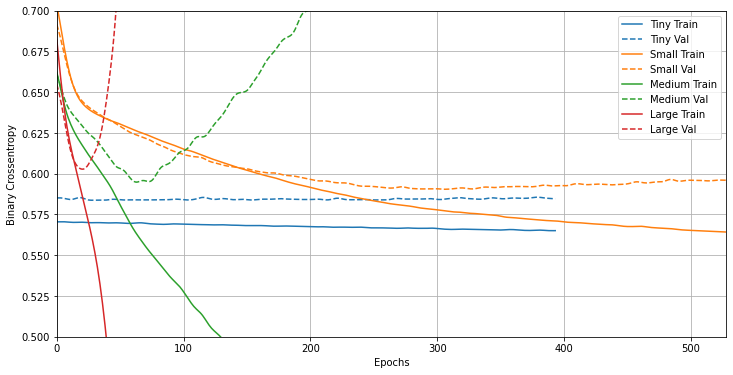

In [15]:
import tensorflow_docs.plots

#
# A continuación se grafican los resultados obtenidos para
# los modelos estimados anteriormente. Los modelos Medium
# y Large presentan claramente sobre-entrenamiento
# (métrica de pérdida creciente para el conjunto de
# validación y metríca descendente para el conjunto
# de entrenamiento)
#
# Note que el modelo Tiny no presenta sobreajuste.
#
plt.figure(figsize=(12, 6))
plotter = tfdocs.plots.HistoryPlotter(
    metric="binary_crossentropy",
    smoothing_std=10,
)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])
plt.show()

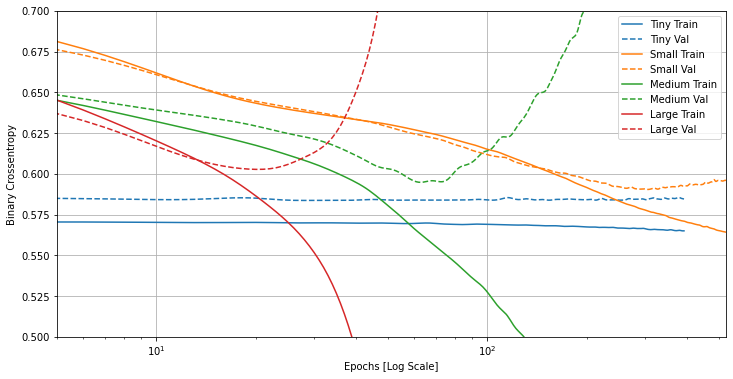

In [16]:
#
# Esta es la misma gráfica anterior, pero con
# escala logaritmica en el eje X
#
plt.figure(figsize=(12, 6))
plotter.plot(size_histories)
a = plt.xscale("log")
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")
plt.show()

## Visualización en TensorBoard

```python
#
# Carga la extensión de TensorBoard
#
%load_ext tensorboard
```

```python
#
# Carga TensorBoard al notebook
#
%tensorboard --host=0.0.0.0 --logdir {LOGDIR}
```

![TensorBoard](assets/tensorboard-gui.png)

## Estrategias para evitar el sobreajuste

In [17]:
#
# Borra la carpeta con los resulados para la regularizacion
#
!rm -rf {LOGDIR + "/regularizers"}

#
# Copia los resultados del modelo Tiny para efectos
# de comparación
#
!mkdir -p {LOGDIR + "/regularizers"}
!cp -R {LOGDIR + "/sizes/Tiny"}  {LOGDIR + "/regularizers/Tiny"}


#
# Diccionario para almacenar los resultados de los modelos
#
regularizer_histories = {}

#
# Copia el resultado del modelo Tiny (que no tiene
# sobreajuste)
#
regularizer_histories["Tiny"] = size_histories["Tiny"]

In [18]:
#
# Regularización L1
#
L1_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1(
                l1=0.001,
            ),
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1(
                l1=0.001,
            ),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1(
                l1=0.001,
            ),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1(
                l1=0.001,
            ),
        ),
        tf.keras.layers.Dense(1),
    ]
)

regularizer_histories["L1"] = compile_and_fit(L1_model, "regularizers/L1")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4904,  binary_crossentropy:0.7294,  loss:26.7411,  val_accuracy:0.5120,  val_binary_crossent

In [19]:
#
# Regularización L2
#
L2_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=0.001,
            ),
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=0.001,
            ),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=0.001,
            ),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L2(
                l2=0.001,
            ),
        ),
        tf.keras.layers.Dense(1),
    ]
)

regularizer_histories["L2"] = compile_and_fit(L2_model, "regularizers/L2")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4999,  binary_crossentropy:0.7994,  loss:2.3109,  val_accuracy:0.4700,  val_binary_crossentr

In [20]:
#
# Regularización L1l2
#
L1L2_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1L2(
                l1=0.001,
                l2=0.001,
            ),
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1L2(
                l1=0.001,
                l2=0.001,
            ),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1L2(
                l1=0.001,
                l2=0.001,
            ),
        ),
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.L1L2(
                l1=0.001,
                l2=0.001,
            ),
        ),
        tf.keras.layers.Dense(1),
    ]
)

regularizer_histories["L1L2"] = compile_and_fit(L1L2_model, "regularizers/L1L2")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4934,  binary_crossentropy:0.7159,  loss:27.2194,  val_accuracy:0.4600,  val_binary_crossent

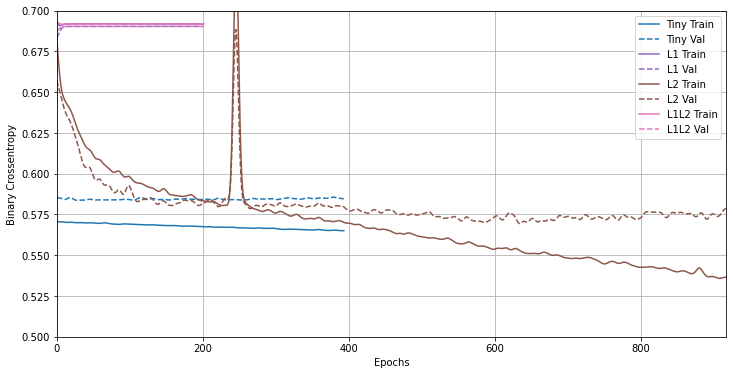

In [21]:
plt.figure(figsize=(12, 6))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])
plt.show()

In [22]:
result = L2_model(features)
regularization_loss = tf.add_n(L2_model.losses)

In [23]:
#
# Dropout
#
dropout_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            512,
            activation="elu",
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            512,
            activation="elu",
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            512,
            activation="elu",
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1),
    ]
)

regularizer_histories["dropout"] = compile_and_fit(
    dropout_model, "regularizers/dropout"
)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)              

(0.5, 0.7)

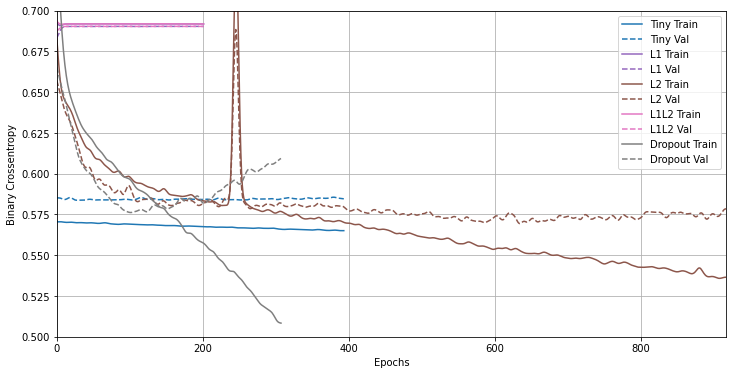

In [24]:
plt.figure(figsize=(12, 6))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [25]:
#
# L2 + Dropout
#
combined_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            512,
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            activation="elu",
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            512,
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            activation="elu",
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            512,
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            activation="elu",
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1),
    ]
)

regularizer_histories["combined"] = compile_and_fit(
    combined_model, "regularizers/combined"
)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)              

(0.5, 0.7)

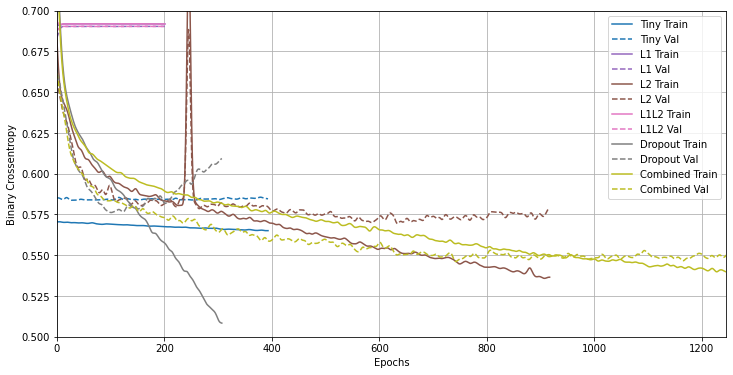

In [26]:
plt.figure(figsize=(12, 6))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])